## Setup

In [1]:
import numpy as np
np.random.seed(16)

import sklearn
from sklearn import datasets

## Projected

In [2]:
def project(l, x, R):
  
  def proj_to_l2ball(x, R):
      temp = np.maximum(R, np.linalg.norm(x, 2))
      return R*x / np.maximum(R, np.linalg.norm(x, 2))

  def proj_to_simplex(x, R):
    if np.sum(x)==R and np.alltrue(x>=0):
      return x
    u = np.sort(x)[::-1]
    cum = np.cumsum(u)
    K = np.nonzero([(cum[k]-R)/(k+1) for k in range(len(x))] < u)[0][-1] + 1
    tau = (cum[K-1]  - R)/K
    xn = np.maximum(x-tau, 0)
    assert(np.allclose(np.sum(xn), R, rtol=1e-4)), 'not properly projected to simplex'
    return xn

  def proj_to_l1(x, R = 5):
    u = np.abs(x)
    if u.sum() <= R:
        return x
    return proj_to_simplex(u, R) * np.sign(x)

  if l==1:
    return proj_to_l1(x, R)
  elif l==2:
    return proj_to_l2ball(x, R)
  else:
    return proj_to_simplex(x, R)


In [3]:
def ProjGD_Ball(th0, F, gradF, step, max_iter, projectionfunction, tol, R=1):
    iters =[th0]
    errs = []
    th = th0

    k = 0
    while (True):
        th = projectionfunction(th - step*gradF(th), R)
        # print(np.linalg.norm(th,2), f'<={radius}: ', np.linalg.norm(th, 2)<=radius)
        iters.append(th)
        errs.append(np.linalg.norm(iters[-1] - iters[-2]))
        if (k>max_iter or errs[-1]<=tol):
            break
        k = k + 1
        
    return np.array(iters).T, np.array(errs)

A general equation of a paraboloid is stated with three terms:
$$P(x) = x^{T}Ax + Cx + d $$ 
for $A \in \mathbb{R}^{n\times{n}} \succ{0}$, $C\in\mathbb{R}^{n}$, and $d\in\mathbb{R}$

#### Generating data

In [4]:
dim = 2
#Generate problem
A = datasets.make_spd_matrix(dim, random_state=16)
A = A

B = np.random.uniform(-1, 1, dim+1)
B = B/np.sum(B)

d = B[-1]
B = np.delete(B, -1)

#goal: recover x given some observed y - values
P = lambda x: x.T.dot(x.T.dot(A)) + B.dot(x) + d
gradP = lambda x: A.dot(x) + B

#### Determine 
$$ \min_{x} P(x) \text{    s.t.   } ||{x}||\leq{R} $$

where projection $$\Pi_{A}(x) = \frac{R}{max(||x||_2, R)}x$$ 

Choose an arbitrary starting point $x_0$ on the boundary of the $\ell_2$-ball with radius $R$

In [5]:
R = 0.5
x0 = np.random.randn(dim)
maxiter = 100

The gradient writes as 
$$\nabla{P} = Ax + C$$


Run an iteration of PGD-l2

In [6]:
iters = []
errs = []
lball = [1, 2]
for l in lball:
    proj_rule = lambda x, R: project(l, x, R)
    x = project(l, x0, R)
    it, e = ProjGD_Ball(x, P, gradP, tol=1e-8, step=0.01, max_iter=maxiter, R=R, projectionfunction=proj_rule)
    iters.append(it)
    errs.append(e)
# errs = np.array(errs)

#### Consider the errors

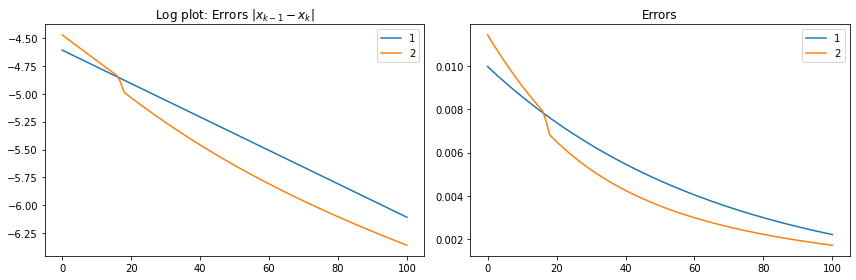

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,4), tight_layout=True)
plt.subplot(1,2,1)
for i in errs:
    plt.plot(np.log(i[1:]))
plt.legend(lball)
# plt.plot(np.log(errs))
plt.title(r'Log plot: Errors $|x_{k-1}-x_{k}|$')
plt.subplot(1,2,2)
for i in errs:
    plt.plot(i[1:])
plt.legend(lball)
plt.title('Errors');


#### Plot
And plot the results

In [8]:
n = 50
t = np.linspace(-3, 3, n)
X, Y = np.meshgrid(t,t)

In [9]:
vals = np.zeros(iters.shape[1])
for i in range(iters.shape[1]):
    vals[i] = P(iters[:,i])

temp = np.zeros(n*n)
Z = np.vstack((X.ravel(), Y.ravel()))
for i in range(Z.shape[1]):
    temp[i] = (P(Z[0:2, i]))
    
temp = temp.reshape((n,n))

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = 2*(np.cos(u) * np.sin(v))
y = 2*(np.sin(u) * np.sin(v))
z = np.cos(v)*2
# fig = plt.figure(figsize=(8,8))
# ax = plt.axes(projection='3d')
# ax.plot_wireframe(x, y, z, alpha=0.3, color='k')
# plt.show()

In [ ]:
# %matplotlib qt
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(iters[0,0], iters[1,0], vals[0], s=5, c='r', label='starting point') #starting point
# ax.plot3D(iters[0], iters[1], vals, c='maroon', linewidth=2, label= 'iterations of projected Gradient');
ax.scatter3D(iters[0,1:], iters[1,1:], vals[1:], c='b', s=5, label='iterations of projected Gradient')
ax.plot_surface(X, Y, temp, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.1) #c=Z[2], cmap='Oranges', alpha=0.3);
ax.plot_wireframe(x, y, z, alpha=0.3, color='k')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_zlim(-3,3)
# ax.axis('off');
ax.legend();

## Franke-Wolfe / Conditional gradient

For conditional gradient on the $\ell_2$-ball with radius $R$, we solve for 

$s_{k+1} \in \underset{s \in B(0,R)}{\mathrm{argmin}} \big\{ f(x_k) + \langle\ \nabla f(x_k), s - x_k \rangle\ \big\}$ to obtain: 

$$s_{k+1,j} = - R \frac{sign(\nabla f_j(x_k))|\nabla f_j(x_k)|}{||\nabla f(x_k)||_2}$$

In [10]:
def argmin(xk, R, q):
    def argmin_l2ball(xk, q, R):
        # for lq ball
        p = q/(q-1)
        a = np.zeros_like(xk)
        denum = np.sum(np.abs(xk)**p)**(1/q)
        for j in range(len(xk)):
            a[j] = - R*(np.sign(xk[j])*np.abs(xk[j])**(p-1))/denum        
        return a

    def argmin_l1ball(xk, R):
        d = len(xk)
        k0 = np.argmax(np.abs(xk))
        return -R*np.sign(xk[k0])*np.eye(1,d, k0).reshape(-1)


    if q==1:
        return argmin_l1ball(xk, R)
    else:
        return argmin_l2ball(xk, q, R)

def extrpt(dim, R, q):
    def extremept_l2(dim, q, R):
        # for lq ball
        ext = np.random.randn(dim)
        return R*(ext / np.linalg.norm(ext, q))

    def extremept_l1(dim, R): 
        i = int(np.random.choice(dim, 1))
        return R*np.eye(1,dim, i).reshape(-1)

    if q==1:
        return extremept_l1(dim, R)
    else:
        return extremept_l2(dim, q, R)

def backtracking_ls(sk, f, gradf):
    maxiter = 100
    a = 0.25 #0<a<0.5
    b = 0.5 #0<b<1
    nu = 1
    it = 0
    while True:
        if f(sk - nu*gradf(sk)) >= (f(sk) - a*nu*np.linalg.norm(sk,2)**2):
            # print(f'ls: theta found at iter {it}')
            return nu
        elif it > maxiter:
            print('not found')
            break
        nu = b*nu
        it = it+1
    return 1/0
        
def updatetheta(flag, k, sk, f, gradf):
    if flag=='fixed':
        return 2/(k+2)
    elif flag == 'ls':
        return backtracking_ls(sk, f, gradf)
    else:
        print('Error update rule')
        return

def CondGD(f, gradf, R, pick_theta_rule, extr_pt_rule, argminrule, dim, maxit=500):
    x0 = extr_pt_rule(dim, R)
    k = 0
    x = [x0]
    errs = [1e10]
    while (k<=maxit):
        sk = argminrule(gradf(x[-1]), R)

        if np.dot(gradf(x[k]), sk-x[-1]) >= 0:
            print(f'Success at iter {k}')
            break
        thk = pick_theta_rule(k, sk)
        
        x.append( thk*sk + (1-thk)*x[-1])
        errs.append(np.linalg.norm(x[-1] - x[-2], 2))
        k = k+1
    if k>maxit:
        print('Cond: Not found')
    return np.array(x), np.array(errs)

In [11]:
def rules(lball):
    theta_rule = lambda k, sk: updatetheta('fixed', k, sk, f=P, gradf=gradP)
    extr_rule = lambda d, R: extrpt(d, R, lball)
    argm_rule = lambda x, R: argmin(x, R, lball)
    proj_rule = lambda x, R: project(lball, x, R)

    return theta_rule, extr_rule, argm_rule, proj_rule

theta_rule, extr_rule, argm_rule, proj_rule = rules(lball=1)

maxit=100
R=1
step = 0.001
tol = 1e-8

iter_cond, err_cond = CondGD(f=P, gradf=gradP, R=R, pick_theta_rule=theta_rule, extr_pt_rule=extr_rule, argminrule=argm_rule, dim=dim, maxit=maxit)
iter_proj, err_proj = ProjGD_Ball(x0, P, gradP, tol=tol, step=step, max_iter=maxit, R=R, projectionfunction=proj_rule)

Cond: Not found


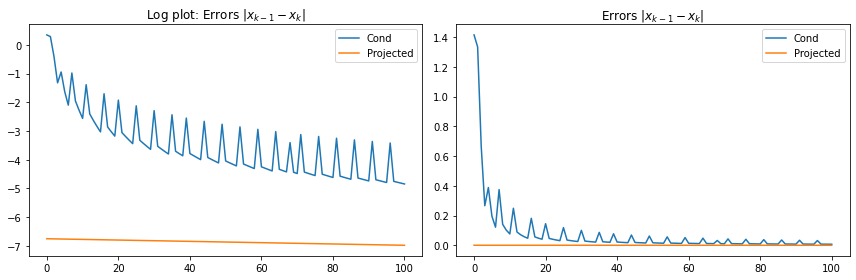

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4), tight_layout=True)
plt.subplot(1,2,1)
plt.plot(np.log(err_cond[1:]))
plt.plot(np.log(err_proj[1:]))
plt.legend(('Cond', 'Projected'))
plt.title(r'Log plot: Errors $|x_{k-1}-x_{k}|$')
plt.subplot(1,2,2)
plt.plot(err_cond[1:])
plt.plot(err_proj[1:])
plt.legend(('Cond', 'Projected'))
plt.title(r'Errors $|x_{k-1}-x_{k}|$');

In [13]:
print("Final Error: ", err_cond[-1], err_proj[-1])

Final Error:  0.00786391890906878 0.0009293873921967755


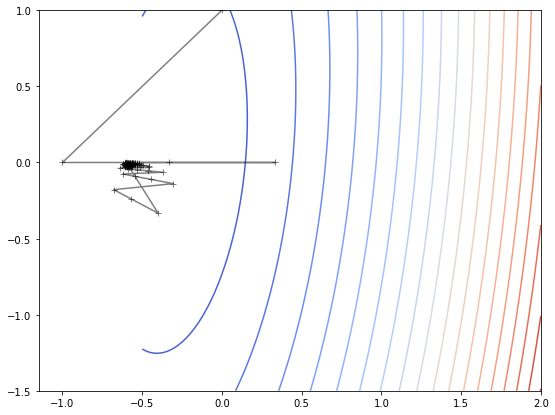

In [14]:
t = np.linspace(-0.5, 2, 200)
X, Y = np.meshgrid(np.linspace(-0.5, 2, 100), np.linspace(-1.5, 1, 100))
Z = np.zeros_like(X)
for i in range(len(X)):
    for j in range(len(Y)):
        Z[i,j] = P(np.array([X[i,j], Y[i,j]]))
# Z = np.reshape(Z, X.shape)
plt.figure(figsize=(9, 7))
plt.contour(X, Y, Z, 20, cmap='coolwarm');
plt.plot(iter_cond[:,0], iter_cond[:, 1], marker = '+', color = 'k', alpha=0.5);